<a href="https://colab.research.google.com/github/Rich-sam/-sentiment-analysis-model/blob/main/samburu_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 12

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [3]:
# Cell 2: Load and prepare the data
def excel_to_date(excel_date):
    """Convert Excel serial date to datetime object"""
    if pd.notna(excel_date):
        return datetime(1899, 12, 30) + timedelta(days=int(excel_date))
    return None

In [5]:
from google.colab import files
import io

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  # Assuming the uploaded file is a CSV
  df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))

print("Data loaded successfully.")
print(df.head())

Saving precipation_samburu.csv to precipation_samburu.csv
User uploaded file "precipation_samburu.csv" with length 2198332 bytes
Data loaded successfully.
    Date  AngataNanyokie  Baawa  Burat  Chari  Cherab  ChuroAmaya  Elbarta  \
0  33239           3.373  0.878  6.702  6.212   1.249       0.659    0.473   
1  33240           0.027  0.013  0.008  0.013   0.008       0.052    0.424   
2  33241           0.342  0.125  0.462  0.026   0.051       0.000    5.326   
3  33242           0.000  0.000  0.290  0.046   0.068       0.000    0.000   
4  33243           0.063  0.550  0.125  0.088   0.031       0.007    0.030   

   Lodokejek  Logologo  ...  Salama  Segera  Sosiani  SugutaMarmar  Tigithi  \
0      0.122     1.626  ...   0.566   2.528    1.318         0.052    5.578   
1      0.221     0.800  ...   0.073   0.224    0.311         0.002    1.049   
2      0.000     0.081  ...   0.027   0.292    0.026         0.000    3.656   
3      0.000     0.691  ...   0.009   0.082    0.000        

In [6]:
# Convert dates
df['Date'] = df['Date'].apply(excel_to_date)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

In [7]:
df.head()

,Date,AngataNanyokie,Baawa,Burat,Chari,Cherab,ChuroAmaya,Elbarta,Lodokejek,Logologo,...,Sosiani,SugutaMarmar,Tigithi,Turbi,WambaEast,WambaNorth,WambaWest,Waso,Year,Month
0,1991-01-01,3.373,0.878,6.702,6.212,1.249,0.659,0.473,0.122,1.626,...,1.318,0.052,5.578,2.108,1.194,0.215,0.806,6.378,1991,1
1,1991-01-02,0.027,0.013,0.008,0.013,0.008,0.052,0.424,0.221,0.800,...,0.311,0.002,1.049,0.174,1.055,2.322,0.474,0.323,1991,1
2,1991-01-03,0.342,0.125,0.462,0.026,0.051,0.000,5.326,0.000,0.081,...,0.026,0.000,3.656,0.518,0.001,0.345,0.004,0.004,1991,1
3,1991-01-04,0.000,0.000,0.290,0.046,0.068,0.000,0.000,0.000,0.691,...,0.000,0.000,0.405,0.200,0.046,0.000,0.090,0.034,1991,1
4,1991-01-05,0.063,0.550,0.125,0.088,0.031,0.007,0.030,1.372,0.041,...,0.138,0.114,0.595,0.000,0.889,0.299,0.980,0.242,1991,1


In [8]:
# Define seasons
def get_season(month):
    if month in [3, 4, 5]:
        return 'MAM'
    elif month in [10, 11, 12]:
        return 'OND'
    else:
        return 'Other'

df['Season'] = df['Month'].apply(get_season)

print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Years covered: {df['Year'].min()} to {df['Year'].max()}")


Date range: 1991-01-01 00:00:00 to 2024-12-31 00:00:00
Years covered: 1991 to 2024


In [9]:
# Define baseline period (1990-2020)
baseline_start = 1990
baseline_end = 2020
baseline_mask = (df['Year'] >= baseline_start) & (df['Year'] <= baseline_end)
df_baseline = df[baseline_mask].copy()

print(f"\nBaseline period: {baseline_start}-{baseline_end}")
print(f"Baseline data points: {len(df_baseline)} days")


Baseline period: 1990-2020
Baseline data points: 10958 days


In [10]:
# Get location columns (all except metadata)
location_cols = [col for col in df.columns if col not in ['Date', 'Year', 'Month', 'Season', 'SEASON', 'YEAR']]
print(f"Number of rainfall stations: {len(location_cols)}")
print(f"Sample stations: {location_cols[:5]}")

Number of rainfall stations: 32
Sample stations: ['AngataNanyokie', 'Baawa', 'Burat', 'Chari', 'Cherab']


In [11]:
# Cell 3: Define locations of interest
# You can modify this list based on your area of interest

target_locations = [
    'Maralal',
    'WambaEast',  # proxy for Wamba
    'Waso',
    'SugutaMarmar',  # Suguta
    'Lodokejek',
    'Oldonyiro',
    'MukogodoEast'
]

# Check which locations exist
available_locations = []
for loc in target_locations:
    if loc in df.columns:
        available_locations.append(loc)
        print(f"✓ {loc} - FOUND")
    else:
        # Try to find similar
        similar = [col for col in location_cols if loc.lower() in col.lower()]
        if similar:
            print(f"✗ {loc} - NOT FOUND. Similar: {similar}")
        else:
            print(f"✗ {loc} - NOT FOUND")

✓ Maralal - FOUND
✓ WambaEast - FOUND
✓ Waso - FOUND
✓ SugutaMarmar - FOUND
✓ Lodokejek - FOUND
✓ Oldonyiro - FOUND
✓ MukogodoEast - FOUND


In [22]:
# Use available locations
target_locations = available_locations
print(f"\nAnalyzing: {target_locations}")


Analyzing: ['Maralal', 'WambaEast', 'Waso', 'SugutaMarmar', 'Lodokejek', 'Oldonyiro', 'MukogodoEast']


In [28]:
# Cell 4: Function to calculate all climate parameters for a location

def calculate_climate_parameters(data, location, baseline_years=(1990, 2020)):
    """
    Calculate all key climate parameters for a single location

    Parameters:
    -----------
    data : DataFrame
        Full dataset with Date, Year, Season columns
    location : str
        Name of the location/station
    baseline_years : tuple
        Start and end year for baseline period

    Returns:
    --------
    dict : All calculated parameters
    """

    results = {}
    location_data = data[['Date', 'Year', 'Season', location]].copy()
    location_data = location_data.dropna(subset=[location])

    # Filter baseline period
    baseline_data = location_data[
        (location_data['Year'] >= baseline_years[0]) &
        (location_data['Year'] <= baseline_years[1])
    ].copy()

    if len(baseline_data) == 0:
        return None

    # =================================================================
    # 1. Seasonal totals and variability
    # =================================================================
    seasonal_totals = baseline_data.groupby(['Year', 'Season'])[location].sum().reset_index()

    mam_data = seasonal_totals[seasonal_totals['Season'] == 'MAM'][location].values
    ond_data = seasonal_totals[seasonal_totals['Season'] == 'OND'][location].values
    other_data = seasonal_totals[seasonal_totals['Season'] == 'Other'][location].values

    results['Seasonal'] = {
        'MAM': {
            'mean': np.mean(mam_data) if len(mam_data) > 0 else np.nan,
            'std': np.std(mam_data) if len(mam_data) > 0 else np.nan,
            'cv': np.std(mam_data)/np.mean(mam_data) if len(mam_data) > 0 and np.mean(mam_data) > 0 else np.nan,
            'min': np.min(mam_data) if len(mam_data) > 0 else np.nan,
            'max': np.max(mam_data) if len(mam_data) > 0 else np.nan,
            'years': len(mam_data)
        },
        'OND': {
            'mean': np.mean(ond_data) if len(ond_data) > 0 else np.nan,
            'std': np.std(ond_data) if len(ond_data) > 0 else np.nan,
            'cv': np.std(ond_data)/np.mean(ond_data) if len(ond_data) > 0 and np.mean(ond_data) > 0 else np.nan,
            'min': np.min(ond_data) if len(ond_data) > 0 else np.nan,
            'max': np.max(ond_data) if len(ond_data) > 0 else np.nan,
            'years': len(ond_data)
        },
        'Other': {
            'mean': np.mean(other_data) if len(other_data) > 0 else np.nan,
            'std': np.std(other_data) if len(other_data) > 0 else np.nan,
            'years': len(other_data)
        }
    }

    # =================================================================
    # 2. Percentiles (all data and rainy days only)
    # =================================================================
    rainy_days = baseline_data[location].values[baseline_data[location].values > 0]

    percentiles = [5, 10, 25, 50, 75, 90, 95, 99]
    results['Percentiles'] = {
        'all_days': {f'P{p}': np.percentile(baseline_data[location].values, p) for p in percentiles},
        'rainy_days': {f'P{p}': np.percentile(rainy_days, p) for p in percentiles} if len(rainy_days) > 0 else {}
    }

    # =================================================================
    # 3. Number of wet days
    # =================================================================
    wet_day_thresholds = [0.1, 1, 5, 10, 20, 30, 40, 50]

    results['WetDays'] = {}
    for thresh in wet_day_thresholds:
        count = (baseline_data[location].values > thresh).sum()
        pct = count / len(baseline_data[location].values) * 100
        results['WetDays'][f'>{thresh} mm'] = {
            'count': count,
            'percentage': pct,
            'days_per_year': count / len(baseline_data['Year'].unique())
        }

    # Wet days by season
    results['WetDays_by_Season'] = {}
    for season in ['MAM', 'OND', 'Other']:
        season_data = baseline_data[baseline_data['Season'] == season][location].values
        if len(season_data) > 0:
            season_wet = (season_data > 0.1).sum()
            season_total = len(season_data)
            results['WetDays_by_Season'][season] = {
                'count': season_wet,
                'percentage': season_wet / season_total * 100 if season_total > 0 else 0
            }

    # =================================================================
    # 4. Extreme events
    # =================================================================
    extreme_thresholds = [20, 30, 40, 50, 60, 80, 100]

    results['ExtremeEvents'] = {}
    for thresh in extreme_thresholds:
        extreme_count = (baseline_data[location].values > thresh).sum()
        results['ExtremeEvents'][f'>{thresh} mm'] = {
            'total_events': extreme_count,
            'events_per_year': extreme_count / len(baseline_data['Year'].unique()),
            'max_value': np.max(baseline_data[location].values[baseline_data[location].values > thresh]) if extreme_count > 0 else 0
        }

    # Extreme events by season
    results['ExtremeEvents_by_Season'] = {}
    for thresh in [20, 50]:
        results['ExtremeEvents_by_Season'][f'>{thresh} mm'] = {}
        for season in ['MAM', 'OND', 'Other']:
            season_data = baseline_data[baseline_data['Season'] == season][location].values
            season_extreme = (season_data > thresh).sum()
            results['ExtremeEvents_by_Season'][f'>{thresh} mm'][season] = season_extreme

    # =================================================================
    # 5. Return periods (using Gumbel distribution)
    # =================================================================
    # For annual maximum daily rainfall
    annual_max = baseline_data.groupby('Year')[location].max().values
    annual_max = annual_max[~np.isnan(annual_max)]

    if len(annual_max) >= 5:
        # Sort for plotting positions
        sorted_max = np.sort(annual_max)[::-1]
        n = len(sorted_max)
        positions = [(i + 1 - 0.44) / (n + 0.12) for i in range(n)]
        reduced_variate = [-np.log(-np.log(p)) for p in positions]

        # Fit Gumbel distribution
        slope, intercept, r_value, p_value, std_err = stats.linregress(reduced_variate, sorted_max)

        return_periods = [2, 5, 10, 25, 30, 50, 100]
        rp_values = {}

        for T in return_periods:
            y_T = -np.log(-np.log(1 - 1/T))
            x_T = intercept + slope * y_T
            rp_values[T] = max(0, x_T)

        results['ReturnPeriods'] = {
            'values': rp_values,
            'params': {'alpha': slope, 'u': intercept, 'r_squared': r_value**2},
            'data': (sorted_max, reduced_variate)
        }

    # For seasonal maxima
    results['ReturnPeriods_Seasonal'] = {}
    for season in ['MAM', 'OND']:
        seasonal_max = baseline_data[baseline_data['Season'] == season].groupby('Year')[location].sum().values
        seasonal_max = seasonal_max[~np.isnan(seasonal_max)]

        if len(seasonal_max) >= 5:
            sorted_max = np.sort(seasonal_max)[::-1]
            n = len(sorted_max)
            positions = [(i + 1 - 0.44) / (n + 0.12) for i in range(n)]
            reduced_variate = [-np.log(-np.log(p)) for p in positions]

            slope, intercept, r_value, p_value, std_err = stats.linregress(reduced_variate, sorted_max)

            rp_values = {}
            for T in return_periods:
                y_T = -np.log(-np.log(1 - 1/T))
                x_T = intercept + slope * y_T
                rp_values[T] = max(0, x_T)

            results['ReturnPeriods_Seasonal'][season] = {
                'values': rp_values,
                'params': {'alpha': slope, 'u': intercept, 'r_squared': r_value**2}
            }

    # 6. General statistics
    # =================================================================
    all_values = baseline_data[location].values
    results['General'] = {
        'total_rainfall': np.sum(all_values),
        'mean_daily': np.mean(all_values),
        'std_daily': np.std(all_values),
        'max_daily': np.max(all_values),
        'rainy_days_count': len(rainy_days),
        'rainy_days_pct': len(rainy_days) / len(all_values) * 100,
        'data_years': len(baseline_data['Year'].unique())
    }

    return results

In [44]:
# Calculate parameters for all target locations
all_location_parameters = {}
for loc in target_locations:
    print(f"Calculating parameters for {loc}...")
    params = calculate_climate_parameters(df, loc, baseline_years=(baseline_start, baseline_end))
    if params:
        all_location_parameters[loc] = params
    else:
        print(f"No data for baseline period for {loc}")

print("\nCalculation complete for all target locations.")

Calculating parameters for Maralal...
Calculating parameters for WambaEast...
Calculating parameters for Waso...
Calculating parameters for SugutaMarmar...
Calculating parameters for Lodokejek...
Calculating parameters for Oldonyiro...
Calculating parameters for MukogodoEast...

Calculation complete for all target locations.


In [45]:
# Display climate parameters for an example location (e.g., 'Maralal')
import json
import numpy as np

def numpy_encoder(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable")

print(f"Climate parameters for Maralal:")
print(json.dumps(all_location_parameters['Maralal'], indent=2, default=numpy_encoder))

Climate parameters for Maralal:
{
  "Seasonal": {
    "MAM": {
      "mean": 186.90096666666668,
      "std": 87.81347157336143,
      "cv": 0.4698395794280434,
      "min": 51.206,
      "max": 376.893,
      "years": 30
    },
    "OND": {
      "mean": 151.99646666666663,
      "std": 71.49063765497938,
      "cv": 0.4703440759038219,
      "min": 54.363,
      "max": 341.764,
      "years": 30
    },
    "Other": {
      "mean": 296.8216000000001,
      "std": 102.78307268080026,
      "years": 30
    }
  },
  "Percentiles": {
    "all_days": {
      "P5": 0.0,
      "P10": 0.0,
      "P25": 0.006,
      "P50": 0.166,
      "P75": 1.188,
      "P90": 5.279200000000004,
      "P95": 9.754349999999997,
      "P99": 20.947010000000002
    },
    "rainy_days": {
      "P5": 0.003,
      "P10": 0.007400000000000091,
      "P25": 0.054,
      "P50": 0.334,
      "P75": 1.7385000000000002,
      "P90": 6.573200000000001,
      "P95": 11.105399999999994,
      "P99": 22.08898
    }
  },
  

In [30]:
# Cell 5: Calculate parameters for all locations

all_results = {}

for loc in target_locations:
    print(f"\n{'='*60}")
    print(f"Calculating parameters for: {loc}")
    print(f"{'='*60}")

    results = calculate_climate_parameters(df, loc, baseline_years=(1990, 2020))

    if results:
        all_results[loc] = results
        print(f"✓ Complete - {results['General']['data_years']} years of data")
        print(f"  Total rainfall: {results['General']['total_rainfall']:.0f} mm")
        print(f"  Rainy days: {results['General']['rainy_days_count']} ({results['General']['rainy_days_pct']:.1f}%)")
    else:
        print(f"✗ Insufficient data for {loc}")


Calculating parameters for: Maralal
✓ Complete - 30 years of data
  Total rainfall: 19072 mm
  Rainy days: 9035 (82.5%)

Calculating parameters for: WambaEast
✓ Complete - 30 years of data
  Total rainfall: 23097 mm
  Rainy days: 8865 (80.9%)

Calculating parameters for: Waso
✓ Complete - 30 years of data
  Total rainfall: 18218 mm
  Rainy days: 9082 (82.9%)

Calculating parameters for: SugutaMarmar
✓ Complete - 30 years of data
  Total rainfall: 18719 mm
  Rainy days: 9012 (82.2%)

Calculating parameters for: Lodokejek
✓ Complete - 30 years of data
  Total rainfall: 21305 mm
  Rainy days: 8923 (81.4%)

Calculating parameters for: Oldonyiro
✓ Complete - 30 years of data
  Total rainfall: 16090 mm
  Rainy days: 9412 (85.9%)

Calculating parameters for: MukogodoEast
✓ Complete - 30 years of data
  Total rainfall: 17659 mm
  Rainy days: 10546 (96.2%)


In [31]:
# Cell 6: Summary Table 1 - Seasonal Statistics (Baseline 1990-2020)

seasonal_summary = []

for loc in target_locations:
    if loc not in all_results:
        continue

    res = all_results[loc]
    row = {'Location': loc}

    # MAM season
    if 'MAM' in res['Seasonal']:
        mam = res['Seasonal']['MAM']
        row['MAM_Mean'] = f"{mam['mean']:.0f}"
        row['MAM_Std'] = f"{mam['std']:.0f}"
        row['MAM_CV'] = f"{mam['cv']:.2f}" if not np.isnan(mam['cv']) else 'N/A'
        row['MAM_Min'] = f"{mam['min']:.0f}"
        row['MAM_Max'] = f"{mam['max']:.0f}"
        row['MAM_Years'] = mam['years']

    # OND season
    if 'OND' in res['Seasonal']:
        ond = res['Seasonal']['OND']
        row['OND_Mean'] = f"{ond['mean']:.0f}"
        row['OND_Std'] = f"{ond['std']:.0f}"
        row['OND_CV'] = f"{ond['cv']:.2f}" if not np.isnan(ond['cv']) else 'N/A'
        row['OND_Min'] = f"{ond['min']:.0f}"
        row['OND_Max'] = f"{ond['max']:.0f}"
        row['OND_Years'] = ond['years']

    # Ratio MAM/OND
    if not np.isnan(mam['mean']) and not np.isnan(ond['mean']) and ond['mean'] > 0:
        row['MAM/OND_Ratio'] = f"{mam['mean']/ond['mean']:.2f}"

    seasonal_summary.append(row)

seasonal_df = pd.DataFrame(seasonal_summary).set_index('Location')

print("\n" + "=" * 90)
print("SEASONAL STATISTICS (1990-2020 Baseline)")
print("=" * 90)
print("Values in mm (rainfall)")
print(seasonal_df.to_string())


SEASONAL STATISTICS (1990-2020 Baseline)
Values in mm (rainfall)
             MAM_Mean MAM_Std MAM_CV MAM_Min MAM_Max  MAM_Years OND_Mean OND_Std OND_CV OND_Min OND_Max  OND_Years MAM/OND_Ratio
Location                                                                                                                        
Maralal           187      88   0.47      51     377         30      152      71   0.47      54     342         30          1.23
WambaEast         305     123   0.40     124     640         30      347     161   0.46     131     795         30          0.88
Waso              230      91   0.39      92     471         30      290     143   0.49     111     833         30          0.79
SugutaMarmar      175      85   0.49      50     369         30      152      73   0.48      45     354         30          1.15
Lodokejek         245      97   0.39      65     451         30      259     107   0.41     121     573         30          0.95
Oldonyiro         186      80  

In [32]:
# Cell 7: Summary Table 2 - Percentiles

percentile_summary = []

for loc in target_locations:
    if loc not in all_results:
        continue

    res = all_results[loc]
    row = {'Location': loc}

    # All days percentiles
    if 'all_days' in res['Percentiles']:
        for p in [50, 75, 90, 95, 99]:
            row[f'AllDays_P{p}'] = f"{res['Percentiles']['all_days'][f'P{p}']:.2f}"

    # Rainy days percentiles
    if 'rainy_days' in res['Percentiles'] and res['Percentiles']['rainy_days']:
        for p in [50, 75, 90, 95, 99]:
            row[f'RainyDays_P{p}'] = f"{res['Percentiles']['rainy_days'][f'P{p}']:.2f}"

    percentile_summary.append(row)

percentile_df = pd.DataFrame(percentile_summary).set_index('Location')

print("\n" + "=" * 90)
print("PERCENTILES (mm) - Baseline 1990-2020")
print("=" * 90)
print(percentile_df.to_string())


PERCENTILES (mm) - Baseline 1990-2020
             AllDays_P50 AllDays_P75 AllDays_P90 AllDays_P95 AllDays_P99 RainyDays_P50 RainyDays_P75 RainyDays_P90 RainyDays_P95 RainyDays_P99
Location                                                                                                                                      
Maralal             0.17        1.19        5.28        9.75       20.95          0.33          1.74          6.57         11.11         22.09
WambaEast           0.22        1.57        5.77       11.04       27.34          0.49          2.26          7.13         12.69         29.42
Waso                0.14        1.22        4.94        8.99       20.76          0.31          1.75          6.03         10.16         22.24
SugutaMarmar        0.26        1.71        5.25        8.52       16.81          0.54          2.37          6.14          9.55         17.69
Lodokejek           0.26        1.97        5.88        9.87       19.10          0.62          2.77   

In [33]:
# Cell 8: Summary Table 3 - Wet Days Analysis

wetdays_summary = []

for loc in target_locations:
    if loc not in all_results:
        continue

    res = all_results[loc]
    row = {'Location': loc}

    # General wet days
    row['Rainy_Days_Total'] = res['General']['rainy_days_count']
    row['Rainy_Days_%'] = f"{res['General']['rainy_days_pct']:.1f}"

    # Wet days by threshold
    for thresh in [1, 5, 10, 20, 30, 50]:
        key = f'>{thresh} mm'
        if key in res['WetDays']:
            row[f'Days_>{thresh}mm'] = res['WetDays'][key]['count']
            row[f'Pct_>{thresh}mm'] = f"{res['WetDays'][key]['percentage']:.2f}%"
            row[f'PerYear_>{thresh}mm'] = f"{res['WetDays'][key]['days_per_year']:.1f}"

    # Wet days by season
    if 'WetDays_by_Season' in res:
        for season in ['MAM', 'OND', 'Other']:
            if season in res['WetDays_by_Season']:
                row[f'{season}_WetDays_%'] = f"{res['WetDays_by_Season'][season]['percentage']:.1f}%"

    wetdays_summary.append(row)

wetdays_df = pd.DataFrame(wetdays_summary).set_index('Location')

print("\n" + "=" * 90)
print("WET DAYS ANALYSIS - Baseline 1990-2020")
print("=" * 90)
print(wetdays_df.to_string())


WET DAYS ANALYSIS - Baseline 1990-2020
              Rainy_Days_Total Rainy_Days_%  Days_>1mm Pct_>1mm PerYear_>1mm  Days_>5mm Pct_>5mm PerYear_>5mm  Days_>10mm Pct_>10mm PerYear_>10mm  Days_>20mm Pct_>20mm PerYear_>20mm  Days_>30mm Pct_>30mm PerYear_>30mm  Days_>50mm Pct_>50mm PerYear_>50mm MAM_WetDays_% OND_WetDays_% Other_WetDays_%
Location                                                                                                                                                                                                                                                                                                 
Maralal                   9035         82.5       2964   27.05%         98.8       1142   10.42%         38.1         530     4.84%          17.7         126     1.15%           4.2          28     0.26%           0.9           3     0.03%           0.1         59.6%         56.8%           52.6%
WambaEast                 8865         80.9       3379   30.84%   

In [34]:
# Cell 9: Summary Table 4 - Extreme Events

extreme_summary = []

for loc in target_locations:
    if loc not in all_results:
        continue

    res = all_results[loc]
    row = {'Location': loc}

    # Extreme events by threshold
    for thresh in [20, 30, 40, 50, 60, 80]:
        key = f'>{thresh} mm'
        if key in res['ExtremeEvents']:
            row[f'Events_>{thresh}mm'] = res['ExtremeEvents'][key]['total_events']
            row[f'PerYear_>{thresh}mm'] = f"{res['ExtremeEvents'][key]['events_per_year']:.2f}"
            if res['ExtremeEvents'][key]['max_value'] > 0:
                row[f'Max_>{thresh}mm'] = f"{res['ExtremeEvents'][key]['max_value']:.0f}"

    # Extreme events by season (>20mm)
    if 'ExtremeEvents_by_Season' in res and '>20 mm' in res['ExtremeEvents_by_Season']:
        for season in ['MAM', 'OND', 'Other']:
            if season in res['ExtremeEvents_by_Season']['>20 mm']:
                row[f'20mm_{season}'] = res['ExtremeEvents_by_Season']['>20 mm'][season]

    # Extreme events by season (>50mm)
    if 'ExtremeEvents_by_Season' in res and '>50 mm' in res['ExtremeEvents_by_Season']:
        for season in ['MAM', 'OND', 'Other']:
            if season in res['ExtremeEvents_by_Season']['>50 mm']:
                row[f'50mm_{season}'] = res['ExtremeEvents_by_Season']['>50 mm'][season]

    extreme_summary.append(row)

extreme_df = pd.DataFrame(extreme_summary).set_index('Location')

print("\n" + "=" * 90)
print("EXTREME EVENTS ANALYSIS - Baseline 1990-2020")
print("=" * 90)
print(extreme_df.to_string())


EXTREME EVENTS ANALYSIS - Baseline 1990-2020
              Events_>20mm PerYear_>20mm Max_>20mm  Events_>30mm PerYear_>30mm Max_>30mm  Events_>40mm PerYear_>40mm Max_>40mm  Events_>50mm PerYear_>50mm Max_>50mm  Events_>60mm PerYear_>60mm Max_>60mm  Events_>80mm PerYear_>80mm  20mm_MAM  20mm_OND  20mm_Other  50mm_MAM  50mm_OND  50mm_Other Max_>80mm
Location                                                                                                                                                                                                                                                                                                        
Maralal                126          4.20        62            28          0.93        62             6          0.20        62             3          0.10        62             1          0.03        62             0          0.00        39        29          58         2         0           1       NaN
WambaEast              219          7.3

In [35]:
# Cell 10: Summary Table 5 - Return Periods (Daily Maxima)

rp_summary = []

return_periods_list = [2, 5, 10, 25, 30, 50, 100]

for loc in target_locations:
    if loc not in all_results:
        continue

    res = all_results[loc]
    row = {'Location': loc}

    if 'ReturnPeriods' in res:
        rp = res['ReturnPeriods']['values']
        row['Gumbel_R2'] = f"{res['ReturnPeriods']['params']['r_squared']:.3f}"

        for T in return_periods_list:
            if T in rp:
                row[f'Daily_{T}yr'] = f"{rp[T]:.0f}"

    rp_summary.append(row)

rp_df = pd.DataFrame(rp_summary).set_index('Location')

print("\n" + "=" * 90)
print("RETURN PERIODS - Daily Maximum Rainfall (mm)")
print("=" * 90)
print(rp_df.to_string())


RETURN PERIODS - Daily Maximum Rainfall (mm)
             Gumbel_R2 Daily_2yr Daily_5yr Daily_10yr Daily_25yr Daily_30yr Daily_50yr Daily_100yr
Location                                                                                          
Maralal          0.835        34        26         20         13         12          8           3
WambaEast        0.698        51        37         28         17         14          8           0
Waso             0.828        33        23         17          9          8          4           0
SugutaMarmar     0.611        27        20         15          9          8          5           1
Lodokejek        0.798        33        26         21         14         13          9           5
Oldonyiro        0.751        31        23         18         12         10          7           2
MukogodoEast     0.861        29        21         15          7          6          2           0


In [36]:
# Cell 11: Summary Table 6 - Seasonal Return Periods

seasonal_rp_summary = []

for loc in target_locations:
    if loc not in all_results:
        continue

    res = all_results[loc]

    if 'ReturnPeriods_Seasonal' in res:
        for season in ['MAM', 'OND']:
            if season in res['ReturnPeriods_Seasonal']:
                row = {'Location': loc, 'Season': season}
                rp = res['ReturnPeriods_Seasonal'][season]['values']
                row['Gumbel_R2'] = f"{res['ReturnPeriods_Seasonal'][season]['params']['r_squared']:.3f}"

                for T in return_periods_list:
                    if T in rp:
                        row[f'{T}yr'] = f"{rp[T]:.0f}"

                seasonal_rp_summary.append(row)

seasonal_rp_df = pd.DataFrame(seasonal_rp_summary)
if len(seasonal_rp_df) > 0:
    seasonal_rp_df = seasonal_rp_df.set_index(['Location', 'Season'])

print("\n" + "=" * 90)
print("RETURN PERIODS - Seasonal Total Rainfall (mm)")
print("=" * 90)
if len(seasonal_rp_df) > 0:
    print(seasonal_rp_df.to_string())
else:
    print("No seasonal return period data available")


RETURN PERIODS - Seasonal Total Rainfall (mm)
                    Gumbel_R2  2yr  5yr 10yr 25yr 30yr 50yr 100yr
Location     Season                                              
Maralal      MAM        0.857  200  124   74   10    0    0     0
             OND        0.765  162  104   65   16    7    0     0
WambaEast    MAM        0.817  323  219  150   63   46    0     0
             OND        0.749  370  240  154   45   24    0     0
Waso         MAM        0.787  243  168  118   55   43    9     0
             OND        0.646  309  202  131   41   24    0     0
SugutaMarmar MAM        0.849  188  114   66    4    0    0     0
             OND        0.793  163  102   62   11    1    0     0
Lodokejek    MAM        0.866  260  176  120   50   36    0     0
             OND        0.769  274  187  129   56   42    2     0
Oldonyiro    MAM        0.813  197  130   85   29   18    0     0
             OND        0.745  240  145   82    3    0    0     0
MukogodoEast MAM        0.874

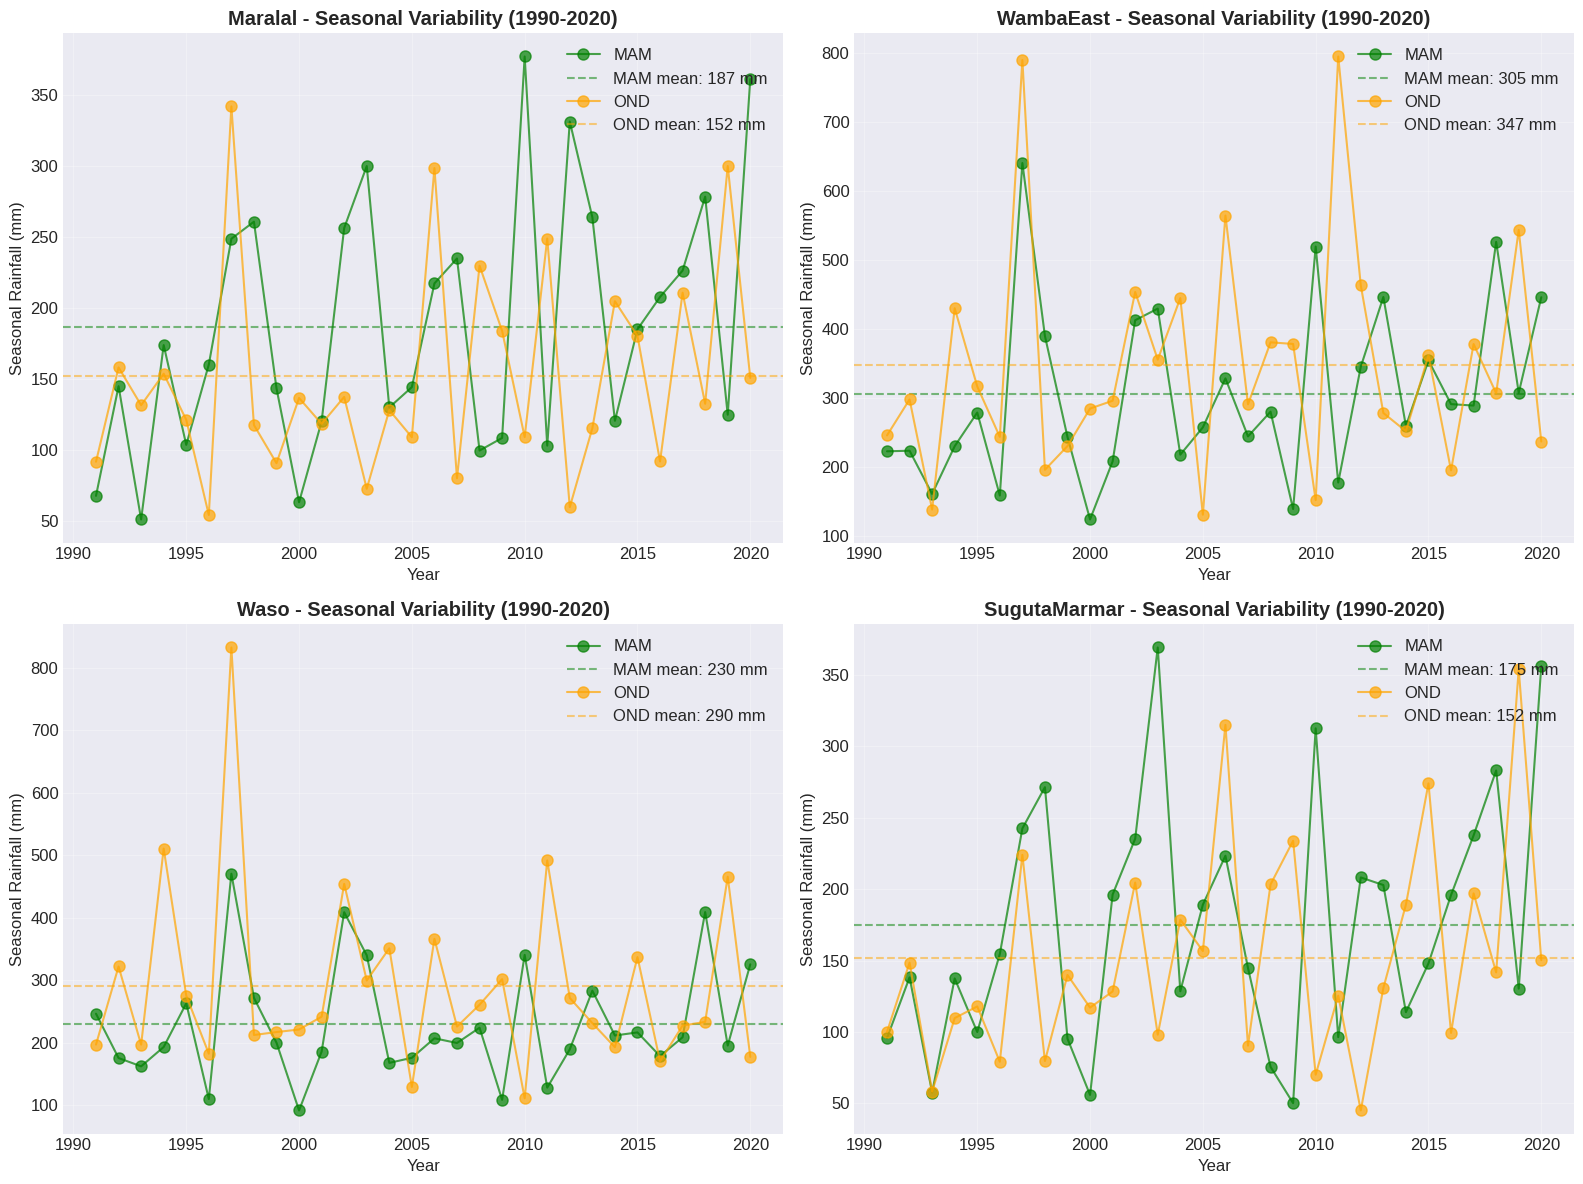

In [37]:
# Cell 12: Visualize Seasonal Variability

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, loc in enumerate(target_locations[:4]):  # First 4 locations
    if loc not in all_results:
        continue

    ax = axes[idx]
    res = all_results[loc]

    # Extract seasonal data from raw data
    loc_data = df_baseline[['Year', 'Season', loc]].dropna()
    seasonal_totals = loc_data.groupby(['Year', 'Season'])[loc].sum().reset_index()

    # Plot
    for season, color in zip(['MAM', 'OND'], ['green', 'orange']):
        season_data = seasonal_totals[seasonal_totals['Season'] == season]
        if len(season_data) > 0:
            ax.plot(season_data['Year'], season_data[loc], 'o-', color=color,
                   label=season, alpha=0.7, markersize=8)

            # Add mean line
            mean_val = season_data[loc].mean()
            ax.axhline(y=mean_val, color=color, linestyle='--', alpha=0.5,
                      label=f'{season} mean: {mean_val:.0f} mm')

    ax.set_xlabel('Year')
    ax.set_ylabel('Seasonal Rainfall (mm)')
    ax.set_title(f'{loc} - Seasonal Variability (1990-2020)', fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

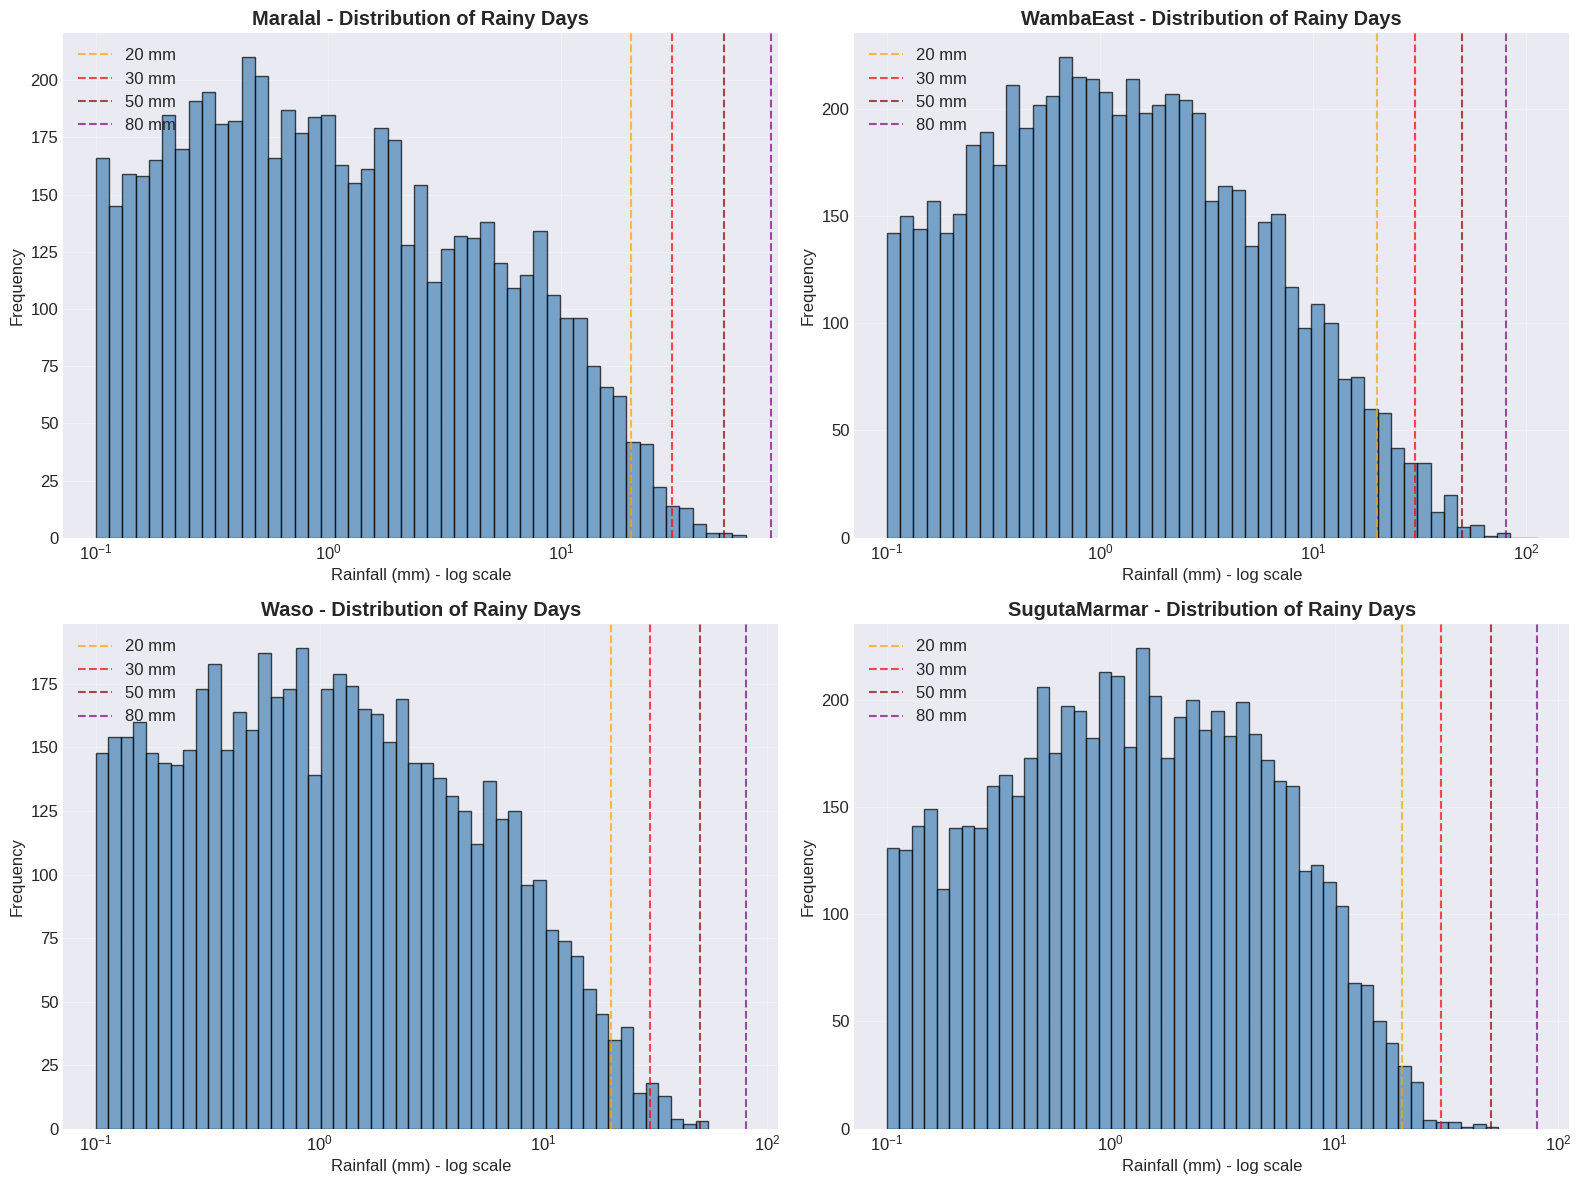

In [38]:
# Cell 13: Visualize Extreme Events Distribution

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, loc in enumerate(target_locations[:4]):  # First 4 locations
    if loc not in all_results:
        continue

    ax = axes[idx]

    # Get all rainfall values
    loc_data = df_baseline[loc].dropna()
    rainy_values = loc_data[loc_data > 0]

    # Create histogram
    bins = np.logspace(np.log10(0.1), np.log10(loc_data.max()), 50)
    ax.hist(rainy_values, bins=bins, alpha=0.7, color='steelblue', edgecolor='black')
    ax.set_xscale('log')

    # Add threshold lines
    for thresh, color in zip([20, 30, 50, 80], ['orange', 'red', 'darkred', 'purple']):
        ax.axvline(x=thresh, color=color, linestyle='--', alpha=0.7, label=f'{thresh} mm')

    ax.set_xlabel('Rainfall (mm) - log scale')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{loc} - Distribution of Rainy Days', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

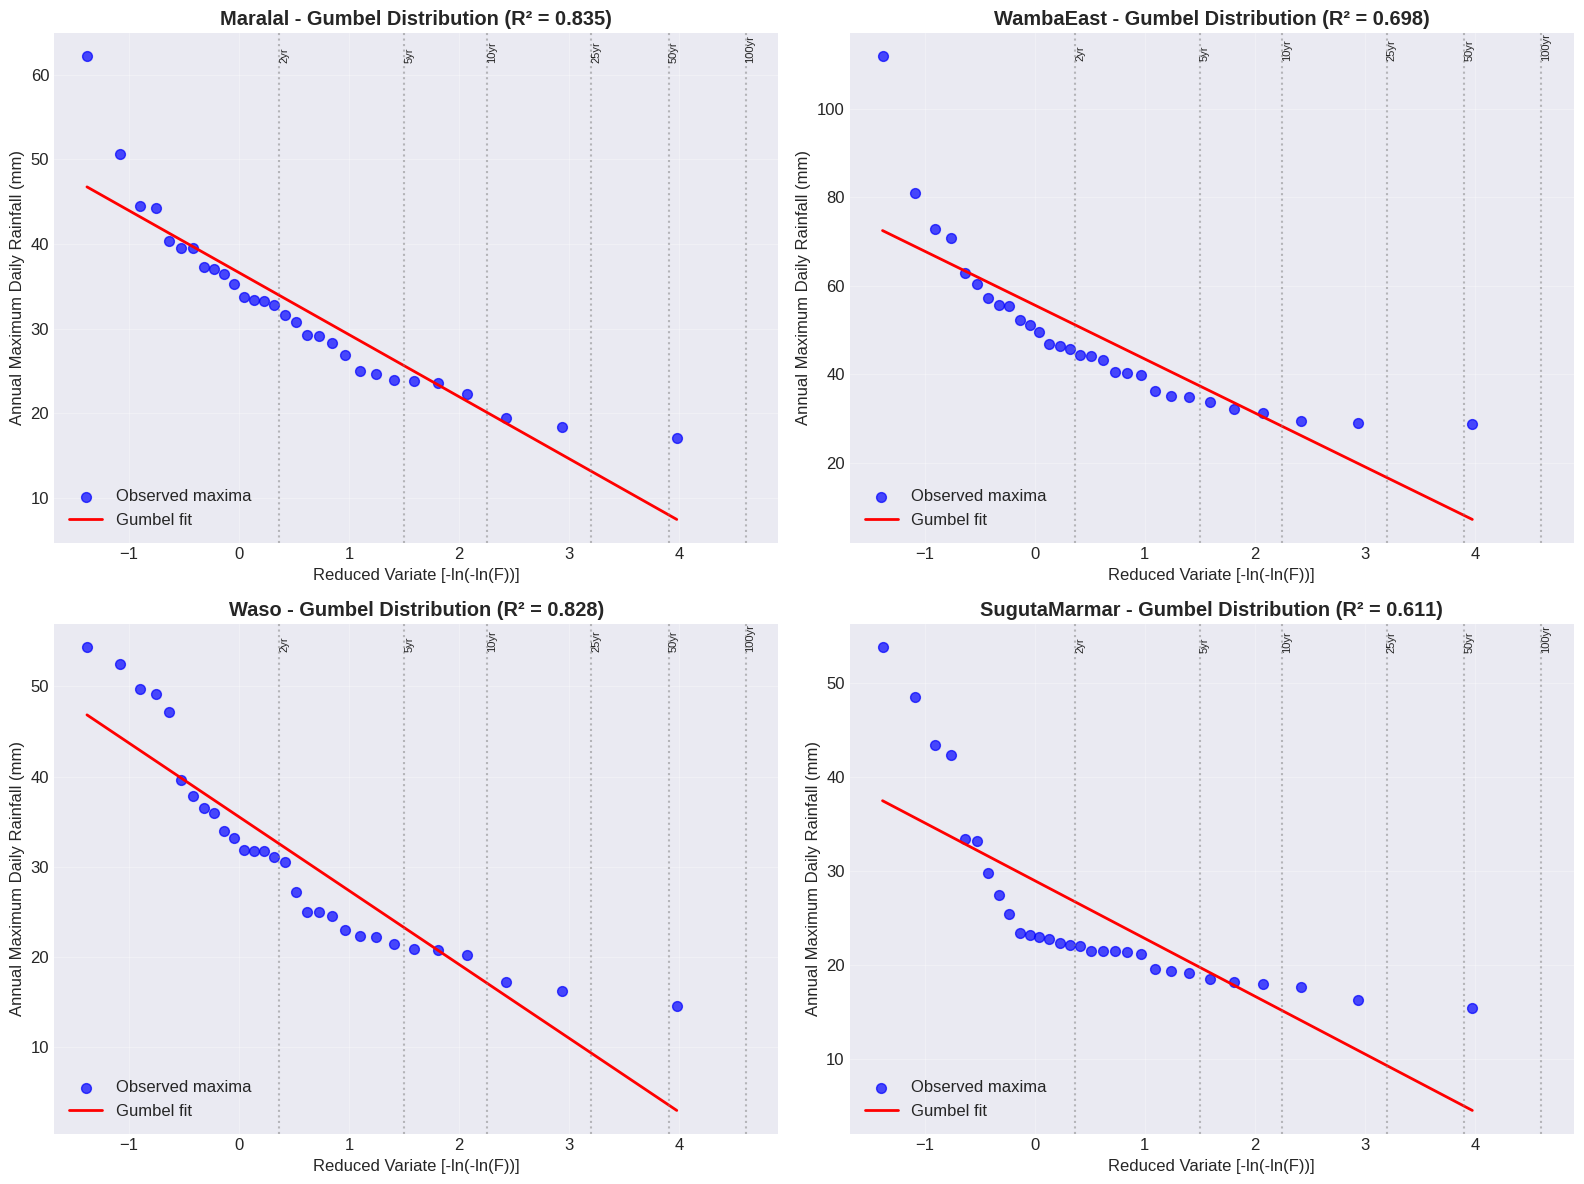

In [39]:
# Cell 14: Visualize Return Periods

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, loc in enumerate(target_locations[:4]):  # First 4 locations
    if loc not in all_results or 'ReturnPeriods' not in all_results[loc]:
        continue

    ax = axes[idx]
    res = all_results[loc]

    # Plot Gumbel fit
    data, rv = res['ReturnPeriods']['data']
    params = res['ReturnPeriods']['params']

    ax.scatter(rv, data, s=50, alpha=0.7, color='blue', label='Observed maxima')

    # Plot fitted line
    rv_range = np.linspace(min(rv), max(rv), 100)
    fitted = params['u'] + params['alpha'] * rv_range
    ax.plot(rv_range, fitted, 'r-', linewidth=2, label='Gumbel fit')

    # Add return period lines
    for T in [2, 5, 10, 25, 50, 100]:
        y_T = -np.log(-np.log(1 - 1/T))
        ax.axvline(x=y_T, color='gray', linestyle=':', alpha=0.5)
        ax.text(y_T, ax.get_ylim()[1]*0.95, f'{T}yr', rotation=90, fontsize=8)

    ax.set_xlabel('Reduced Variate [-ln(-ln(F))]')
    ax.set_ylabel('Annual Maximum Daily Rainfall (mm)')
    ax.set_title(f'{loc} - Gumbel Distribution (R² = {params["r_squared"]:.3f})', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [40]:
# Cell 15: Combined Summary Report

print("\n" + "=" * 90)
print("CLIMATE CONSULTANT REPORT - FINAL SUMMARY")
print("=" * 90)
print(f"\nBaseline Period: 1990-2020")
print(f"Locations Analyzed: {', '.join(target_locations)}")
print(f"Data Source: Daily Rainfall Records")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d')}")

print("\n" + "-" * 90)
print("KEY FINDINGS")
print("-" * 90)

for loc in target_locations[:3]:  # First 3 locations for summary
    if loc not in all_results:
        continue

    res = all_results[loc]

    print(f"\n{loc.upper()}:")

    # Seasonal means
    mam_mean = res['Seasonal']['MAM']['mean']
    ond_mean = res['Seasonal']['OND']['mean']
    print(f"  • Long Rains (MAM): {mam_mean:.0f} mm per season")
    print(f"  • Short Rains (OND): {ond_mean:.0f} mm per season")
    print(f"  • MAM/OND Ratio: {mam_mean/ond_mean:.2f}")

    # Wet days
    print(f"  • Rainy days: {res['General']['rainy_days_pct']:.1f}% of all days")
    print(f"  • Days >20mm: {res['WetDays']['>20 mm']['days_per_year']:.1f} per year")
    print(f"  • Days >50mm: {res['WetDays']['>50 mm']['days_per_year']:.1f} per year")

    # Extreme events
    print(f"  • Extreme events (>50mm): {res['ExtremeEvents']['>50 mm']['total_events']} total")
    print(f"    - MAM: {res['ExtremeEvents_by_Season']['>50 mm']['MAM']}")
    print(f"    - OND: {res['ExtremeEvents_by_Season']['>50 mm']['OND']}")

    # Return periods
    if 'ReturnPeriods' in res:
        rp = res['ReturnPeriods']['values']
        print(f"  • 10-year daily rainfall: {rp[10]:.0f} mm")
        print(f"  • 100-year daily rainfall: {rp[100]:.0f} mm")

print("\n" + "-" * 90)
print("CLIMATE RISK INDICATORS")
print("-" * 90)
print("""
NORMAL CONDITIONS:
  • Daily rainfall < P75 (typically < 5-10 mm)
  • Seasonal totals within ±1 standard deviation of mean

MODERATE RISK (WATCH):
  • Daily rainfall between P75 and P90
  • 1-2 extreme events (>50mm) per year
  • 5-year return period approached

HIGH RISK (ALERT):
  • Daily rainfall between P90 and P95
  • Multiple extreme events in a season
  • 10-year return period approached

EXTREME RISK (WARNING):
  • Daily rainfall > P95
  • >3 extreme events (>50mm) in a season
  • 30-year or higher return period
""")

print("\n" + "=" * 90)
print("END OF REPORT")
print("=" * 90)


CLIMATE CONSULTANT REPORT - FINAL SUMMARY

Baseline Period: 1990-2020
Locations Analyzed: Maralal, WambaEast, Waso, SugutaMarmar, Lodokejek, Oldonyiro, MukogodoEast
Data Source: Daily Rainfall Records
Analysis Date: 2026-02-21

------------------------------------------------------------------------------------------
KEY FINDINGS
------------------------------------------------------------------------------------------

MARALAL:
  • Long Rains (MAM): 187 mm per season
  • Short Rains (OND): 152 mm per season
  • MAM/OND Ratio: 1.23
  • Rainy days: 82.5% of all days
  • Days >20mm: 4.2 per year
  • Days >50mm: 0.1 per year
  • Extreme events (>50mm): 3 total
    - MAM: 2
    - OND: 0
  • 10-year daily rainfall: 20 mm
  • 100-year daily rainfall: 3 mm

WAMBAEAST:
  • Long Rains (MAM): 305 mm per season
  • Short Rains (OND): 347 mm per season
  • MAM/OND Ratio: 0.88
  • Rainy days: 80.9% of all days
  • Days >20mm: 7.3 per year
  • Days >50mm: 0.5 per year
  • Extreme events (>50mm): 14

In [41]:
# Cell 16: Export all results to CSV files

# Save all summary tables
seasonal_df.to_csv('climate_analysis_01_seasonal_stats.csv')
percentile_df.to_csv('climate_analysis_02_percentiles.csv')
wetdays_df.to_csv('climate_analysis_03_wet_days.csv')
extreme_df.to_csv('climate_analysis_04_extreme_events.csv')
rp_df.to_csv('climate_analysis_05_return_periods_daily.csv')
if len(seasonal_rp_df) > 0:
    seasonal_rp_df.to_csv('climate_analysis_06_return_periods_seasonal.csv')

print("\n✓ All results exported to CSV files:")
print("  • climate_analysis_01_seasonal_stats.csv")
print("  • climate_analysis_02_percentiles.csv")
print("  • climate_analysis_03_wet_days.csv")
print("  • climate_analysis_04_extreme_events.csv")
print("  • climate_analysis_05_return_periods_daily.csv")
print("  • climate_analysis_06_return_periods_seasonal.csv")


✓ All results exported to CSV files:
  • climate_analysis_01_seasonal_stats.csv
  • climate_analysis_02_percentiles.csv
  • climate_analysis_03_wet_days.csv
  • climate_analysis_04_extreme_events.csv
  • climate_analysis_05_return_periods_daily.csv
  • climate_analysis_06_return_periods_seasonal.csv


In [42]:
# Cell 2: Define flood threshold levels

print("=" * 80)
print("FLOOD THRESHOLD DEFINITIONS")
print("=" * 80)

flood_levels = {
    'NORMAL': {
        'description': 'Normal conditions, no action needed',
        'color': 'green',
        'code': 0
    },
    'WATCH': {
        'description': 'Monitor conditions, prepare for possible flooding',
        'color': 'yellow',
        'code': 1
    },
    'ALERT': {
        'description': 'High probability of flooding, prepare response',
        'color': 'orange',
        'code': 2
    },
    'WARNING': {
        'description': 'Flooding imminent or occurring, take action',
        'color': 'red',
        'code': 3
    },
    'EMERGENCY': {
        'description': 'Extreme flooding, emergency response required',
        'color': 'darkred',
        'code': 4
    }
}

for level, info in flood_levels.items():
    print(f"\n{level}:")
    print(f"  {info['description']}")

FLOOD THRESHOLD DEFINITIONS

NORMAL:
  Normal conditions, no action needed

WATCH:
  Monitor conditions, prepare for possible flooding

ALERT:
  High probability of flooding, prepare response

  Flooding imminent or occurring, take action

EMERGENCY:
  Extreme flooding, emergency response required


In [46]:
# Cell 3: Method 1 - Using Percentiles for Daily Intensity Thresholds

print("=" * 80)
print("METHOD 1: DAILY INTENSITY THRESHOLDS (Using Percentiles)")
print("=" * 80)

print("""
Based on the percentile analysis of rainy days:

P75-P90:  Heavy rain that can cause localized flooding
P90-P95:  Very heavy rain that can cause flash floods
P95-P99:  Extreme rain that causes widespread flooding
>P99:     Exceptional events exceeding historical norms
""")

# Display thresholds for each location
print("\nDAILY RAINFALL THRESHOLDS (mm):")
print("-" * 60)

for loc in percentile_df.index:
    p75 = float(percentile_df.loc[loc, 'RainyDays_P75']) if 'RainyDays_P75' in percentile_df.columns else 0
    p90 = float(percentile_df.loc[loc, 'RainyDays_P90']) if 'RainyDays_P90' in percentile_df.columns else 0
    p95 = float(percentile_df.loc[loc, 'RainyDays_P95']) if 'RainyDays_P95' in percentile_df.columns else 0
    p99 = float(percentile_df.loc[loc, 'RainyDays_P99']) if 'RainyDays_P99' in percentile_df.columns else 0

    print(f"\n{loc}:")
    print(f"  WATCH  (P75-P90):   {p75:.1f} - {p90:.1f} mm")
    print(f"  ALERT  (P90-P95):   {p90:.1f} - {p95:.1f} mm")
    print(f"  WARNING (P95-P99):  {p95:.1f} - {p99:.1f} mm")
    print(f"  EMERGENCY (>P99):   > {p99:.1f} mm")

METHOD 1: DAILY INTENSITY THRESHOLDS (Using Percentiles)

Based on the percentile analysis of rainy days:

P75-P90:  Heavy rain that can cause localized flooding
P90-P95:  Very heavy rain that can cause flash floods
P95-P99:  Extreme rain that causes widespread flooding
>P99:     Exceptional events exceeding historical norms


DAILY RAINFALL THRESHOLDS (mm):
------------------------------------------------------------

Maralal:
  WATCH  (P75-P90):   1.7 - 6.6 mm
  ALERT  (P90-P95):   6.6 - 11.1 mm
  WARNING (P95-P99):  11.1 - 22.1 mm
  EMERGENCY (>P99):   > 22.1 mm

WambaEast:
  WATCH  (P75-P90):   2.3 - 7.1 mm
  ALERT  (P90-P95):   7.1 - 12.7 mm
  WARNING (P95-P99):  12.7 - 29.4 mm
  EMERGENCY (>P99):   > 29.4 mm

Waso:
  WATCH  (P75-P90):   1.8 - 6.0 mm
  ALERT  (P90-P95):   6.0 - 10.2 mm
  WARNING (P95-P99):  10.2 - 22.2 mm
  EMERGENCY (>P99):   > 22.2 mm

SugutaMarmar:
  WATCH  (P75-P90):   2.4 - 6.1 mm
  ALERT  (P90-P95):   6.1 - 9.6 mm
  WARNING (P95-P99):  9.6 - 17.7 mm
  EMERGE

In [48]:
# Cell 4: Method 2 - Using Return Periods for Design Events

print("=" * 80)
print("METHOD 2: RETURN PERIOD-BASED THRESHOLDS")
print("=" * 80)

print("""
Return periods indicate how rare an event is:
• 2-year event: 50% chance each year (frequent)
• 5-year event: 20% chance each year (moderate)
• 10-year event: 10% chance each year (significant)
• 25-year event: 4% chance each year (rare)
• 50-year event: 2% chance each year (very rare)
• 100-year event: 1% chance each year (extreme)

For flood management:
• 5-year:  Minor flooding, drainage design
• 10-year: Moderate flooding, urban drainage
• 25-year: Major flooding, bridge design
• 50-year: Severe flooding, critical infrastructure
• 100-year: Extreme flooding, dam safety
""")

print("\nRETURN PERIOD THRESHOLDS (mm) - Daily Maximum:")
print("-" * 60)

for loc in rp_df.index:
    print(f"\n{loc}:")
    for col in rp_df.columns:
        if 'yr' in col:
            val = rp_df.loc[loc, col]
            print(f"  {col}: {val} mm")

METHOD 2: RETURN PERIOD-BASED THRESHOLDS

Return periods indicate how rare an event is:
• 2-year event: 50% chance each year (frequent)
• 5-year event: 20% chance each year (moderate)
• 10-year event: 10% chance each year (significant)
• 25-year event: 4% chance each year (rare)
• 50-year event: 2% chance each year (very rare)
• 100-year event: 1% chance each year (extreme)

For flood management:
• 5-year:  Minor flooding, drainage design
• 10-year: Moderate flooding, urban drainage
• 25-year: Major flooding, bridge design
• 50-year: Severe flooding, critical infrastructure
• 100-year: Extreme flooding, dam safety


RETURN PERIOD THRESHOLDS (mm) - Daily Maximum:
------------------------------------------------------------

Maralal:
  Daily_2yr: 34 mm
  Daily_5yr: 26 mm
  Daily_10yr: 20 mm
  Daily_25yr: 13 mm
  Daily_30yr: 12 mm
  Daily_50yr: 8 mm
  Daily_100yr: 3 mm

WambaEast:
  Daily_2yr: 51 mm
  Daily_5yr: 37 mm
  Daily_10yr: 28 mm
  Daily_25yr: 17 mm
  Daily_30yr: 14 mm
  Daily_50y

In [49]:
# Cell 5: Method 3 - Multi-day Accumulation Thresholds

print("=" * 80)
print("METHOD 3: MULTI-DAY ACCUMULATION THRESHOLDS")
print("=" * 80)

print("""
Multi-day accumulation is critical for flood forecasting:
• 3-day:  Short-term soil saturation, flash flood potential
• 5-day:  Medium-term accumulation, river response
• 7-day:  Long-term saturation, basin-wide flooding
• 30-day: Antecedent conditions, groundwater levels
""")

# Calculate 3-day and 7-day percentiles from raw data
# (This would require the full dataset - we'll show the concept)

print("\n" + "-" * 60)
print("RECOMMENDED MULTI-DAY THRESHOLDS:")
print("-" * 60)
print("""
Based on hydrological studies, typical thresholds are:

URBAN FLASH FLOODS:
  • 3-day > 50 mm:  Watch for urban flooding
  • 3-day > 80 mm:  Alert for significant urban flooding
  • 3-day > 120 mm: Warning for severe urban flooding

RIVER FLOODS:
  • 7-day > 100 mm:  River levels rise, watch
  • 7-day > 150 mm:  Bankfull conditions possible, alert
  • 7-day > 200 mm:  Flooding likely, warning

These should be calibrated with local river gauge data.
""")

METHOD 3: MULTI-DAY ACCUMULATION THRESHOLDS

Multi-day accumulation is critical for flood forecasting:
• 3-day:  Short-term soil saturation, flash flood potential
• 5-day:  Medium-term accumulation, river response
• 7-day:  Long-term saturation, basin-wide flooding
• 30-day: Antecedent conditions, groundwater levels


------------------------------------------------------------
RECOMMENDED MULTI-DAY THRESHOLDS:
------------------------------------------------------------

Based on hydrological studies, typical thresholds are:

URBAN FLASH FLOODS:
  • 3-day > 50 mm:  Watch for urban flooding
  • 3-day > 80 mm:  Alert for significant urban flooding
  • 3-day > 120 mm: Warning for severe urban flooding

RIVER FLOODS:
  • 7-day > 100 mm:  River levels rise, watch
  • 7-day > 150 mm:  Bankfull conditions possible, alert
  • 7-day > 200 mm:  Flooding likely, warning

These should be calibrated with local river gauge data.



In [51]:
# Cell 6: Method 4 - Seasonal Antecedent Conditions

print("=" * 80)
print("METHOD 4: SEASONAL ANTECEDENT CONDITIONS")
print("=" * 80)

print("""
The amount of rain that has already fallen in the season
affects how susceptible the ground is to flooding:

• Below normal:  Ground can absorb more water
• Normal:        Typical absorption capacity
• Above normal:  Ground saturated, high runoff
• Well above normal:  Extreme saturation, any rain causes flooding
""")

print("\nSEASONAL STATUS THRESHOLDS:")
print("-" * 60)

for loc in seasonal_df.index:
    mam_mean = float(seasonal_df.loc[loc, 'MAM_Mean'])
    mam_std = float(seasonal_df.loc[loc, 'MAM_Std'])
    ond_mean = float(seasonal_df.loc[loc, 'OND_Mean'])
    ond_std = float(seasonal_df.loc[loc, 'OND_Std'])

    print(f"\n{loc}:")
    print(f"  MAM Season (Long Rains):")
    print(f"    Below normal:  < {mam_mean - mam_std:.0f} mm")
    print(f"    Normal:        {mam_mean - mam_std:.0f} - {mam_mean + mam_std:.0f} mm")
    print(f"    Above normal:  {mam_mean + mam_std:.0f} - {mam_mean + 2*mam_std:.0f} mm")
    print(f"    Well above:    > {mam_mean + 2*mam_std:.0f} mm")

    print(f"  OND Season (Short Rains):")
    print(f"    Below normal:  < {ond_mean - ond_std:.0f} mm")
    print(f"    Normal:        {ond_mean - ond_std:.0f} - {ond_mean + ond_std:.0f} mm")
    print(f"    Above normal:  {ond_mean + ond_std:.0f} - {ond_mean + 2*ond_std:.0f} mm")
    print(f"    Well above:    > {ond_mean + 2*ond_std:.0f} mm")

METHOD 4: SEASONAL ANTECEDENT CONDITIONS

The amount of rain that has already fallen in the season
affects how susceptible the ground is to flooding:

• Below normal:  Ground can absorb more water
• Normal:        Typical absorption capacity
• Above normal:  Ground saturated, high runoff
• Well above normal:  Extreme saturation, any rain causes flooding


SEASONAL STATUS THRESHOLDS:
------------------------------------------------------------

Maralal:
  MAM Season (Long Rains):
    Below normal:  < 99 mm
    Normal:        99 - 275 mm
    Above normal:  275 - 363 mm
    Well above:    > 363 mm
  OND Season (Short Rains):
    Below normal:  < 81 mm
    Normal:        81 - 223 mm
    Above normal:  223 - 294 mm
    Well above:    > 294 mm

WambaEast:
  MAM Season (Long Rains):
    Below normal:  < 182 mm
    Normal:        182 - 428 mm
    Above normal:  428 - 551 mm
    Well above:    > 551 mm
  OND Season (Short Rains):
    Below normal:  < 186 mm
    Normal:        186 - 508 mm
    A

In [53]:
# Cell 7: Method 5 - Extreme Event Frequency

print("=" * 80)
print("METHOD 5: EXTREME EVENT FREQUENCY")
print("=" * 80)

print("""
The frequency of extreme events indicates the
flood-prone nature of an area:

• 1-2 events/year:  Normal variability
• 3-4 events/year:  Active flood season
• 5+ events/year:   Extreme flood year
""")

print("\nEXTREME EVENT FREQUENCY (days >50mm per year):")
print("-" * 60)

for loc in extreme_df.index:
    if 'PerYear_>50mm' in extreme_df.columns:
        freq = float(extreme_df.loc[loc, 'PerYear_>50mm'])
        total = float(extreme_df.loc[loc, 'Events_>50mm']) if 'Events_>50mm' in extreme_df.columns else 0

        print(f"\n{loc}:")
        print(f"  Average: {freq:.2f} days per year")
        print(f"  Total events: {total:.0f}")

        if freq < 1:
            print(f"  Classification: LOW flood frequency")
        elif freq < 2:
            print(f"  Classification: MODERATE flood frequency")
        elif freq < 3:
            print(f"  Classification: HIGH flood frequency")
        else:
            print(f"  Classification: VERY HIGH flood frequency")

METHOD 5: EXTREME EVENT FREQUENCY

The frequency of extreme events indicates the
flood-prone nature of an area:

• 1-2 events/year:  Normal variability
• 3-4 events/year:  Active flood season
• 5+ events/year:   Extreme flood year


EXTREME EVENT FREQUENCY (days >50mm per year):
------------------------------------------------------------

Maralal:
  Average: 0.10 days per year
  Total events: 3
  Classification: LOW flood frequency

WambaEast:
  Average: 0.47 days per year
  Total events: 14
  Classification: LOW flood frequency

Waso:
  Average: 0.07 days per year
  Total events: 2
  Classification: LOW flood frequency

SugutaMarmar:
  Average: 0.03 days per year
  Total events: 1
  Classification: LOW flood frequency

Lodokejek:
  Average: 0.03 days per year
  Total events: 1
  Classification: LOW flood frequency

Oldonyiro:
  Average: 0.03 days per year
  Total events: 1
  Classification: LOW flood frequency

MukogodoEast:
  Average: 0.03 days per year
  Total events: 1
  Classific

In [55]:
# Cell 8: Comprehensive Flood Threshold Table

print("=" * 80)
print("COMPREHENSIVE FLOOD THRESHOLDS BY LOCATION")
print("=" * 80)

# Create a combined thresholds table
threshold_table = []

for loc in percentile_df.index:
    row = {'Location': loc}

    # Get values
    p75 = float(percentile_df.loc[loc, 'RainyDays_P75']) if 'RainyDays_P75' in percentile_df.columns else 0
    p90 = float(percentile_df.loc[loc, 'RainyDays_P90']) if 'RainyDays_P90' in percentile_df.columns else 0
    p95 = float(percentile_df.loc[loc, 'RainyDays_P95']) if 'RainyDays_P95' in percentile_df.columns else 0
    p99 = float(percentile_df.loc[loc, 'RainyDays_P99']) if 'RainyDays_P99' in percentile_df.columns else 0

    # Daily thresholds
    row['Watch_Daily_mm'] = f"{p75:.1f} - {p90:.1f}"
    row['Alert_Daily_mm'] = f"{p90:.1f} - {p95:.1f}"
    row['Warning_Daily_mm'] = f"{p95:.1f} - {p99:.1f}"
    row['Emergency_Daily_mm'] = f"> {p99:.1f}"

    # Return periods
    if loc in rp_df.index:
        for col in rp_df.columns:
            if 'yr' in col:
                row[f'RP_{col}'] = rp_df.loc[loc, col]

    # Extreme event frequency
    if loc in extreme_df.index and 'PerYear_>50mm' in extreme_df.columns:
        row['Extreme_freq_per_year'] = f"{float(extreme_df.loc[loc, 'PerYear_>50mm']):.2f}"

    threshold_table.append(row)

threshold_df = pd.DataFrame(threshold_table)
if 'Location' in threshold_df.columns:
    threshold_df = threshold_df.set_index('Location')

print("\n" + "-" * 80)
print("DAILY THRESHOLDS:")
print("-" * 80)
print(threshold_df[['Watch_Daily_mm', 'Alert_Daily_mm', 'Warning_Daily_mm', 'Emergency_Daily_mm']].to_string())

print("\n" + "-" * 80)
print("RETURN PERIODS (Daily Maxima):")
print("-" * 80)
rp_cols = [col for col in threshold_df.columns if 'RP_' in col]
if rp_cols:
    print(threshold_df[rp_cols].to_string())

COMPREHENSIVE FLOOD THRESHOLDS BY LOCATION

--------------------------------------------------------------------------------
DAILY THRESHOLDS:
--------------------------------------------------------------------------------
             Watch_Daily_mm Alert_Daily_mm Warning_Daily_mm Emergency_Daily_mm
Location                                                                      
Maralal           1.7 - 6.6     6.6 - 11.1      11.1 - 22.1             > 22.1
WambaEast         2.3 - 7.1     7.1 - 12.7      12.7 - 29.4             > 29.4
Waso              1.8 - 6.0     6.0 - 10.2      10.2 - 22.2             > 22.2
SugutaMarmar      2.4 - 6.1      6.1 - 9.6       9.6 - 17.7             > 17.7
Lodokejek         2.8 - 7.0     7.0 - 10.9      10.9 - 19.9             > 19.9
Oldonyiro         1.6 - 4.8      4.8 - 8.4       8.4 - 18.2             > 18.2
MukogodoEast      1.6 - 4.8      4.8 - 8.1       8.1 - 17.4             > 17.4

----------------------------------------------------------------

In [58]:
# Cell 9: Flood Early Warning Decision Matrix

print("=" * 80)
print("FLOOD EARLY WARNING DECISION MATRIX")
print("=" * 80)

print("""
This matrix combines multiple parameters to determine flood risk level.
Use the HIGHEST applicable level for decision-making.
""")

# Create a sample decision matrix for one location
sample_loc = percentile_df.index[0] if len(percentile_df.index) > 0 else "Sample Location"

print(f"\n{'='*60}")
print(f"DECISION MATRIX FOR: {sample_loc}")
print(f"{'='*60}")

matrix_data = {
    'Parameter': [
        'Daily Rainfall (mm)',
        '3-day Accumulation (mm)',
        '7-day Accumulation (mm)',
        'Seasonal Status',
        'Return Period',
        'Extreme Events'
    ],
    'NORMAL': [
        f'< {float(percentile_df.loc[sample_loc, "RainyDays_P75"]):.0f}',
        '< 30',
        '< 50',
        'Below normal',
        '< 2-year',
        '0 per year'
    ],
    'WATCH': [
        f'{float(percentile_df.loc[sample_loc, "RainyDays_P75"]):.0f}-{float(percentile_df.loc[sample_loc, "RainyDays_P90"]):.0f}',
        '30-50',
        '50-80',
        'Normal',
        '2-5 year',
        '1 per year'
    ],
    'ALERT': [
        f'{float(percentile_df.loc[sample_loc, "RainyDays_P90"]):.0f}-{float(percentile_df.loc[sample_loc, "RainyDays_P95"]):.0f}',
        '50-80',
        '80-120',
        'Above normal',
        '5-10 year',
        '2 per year'
    ],
    'WARNING': [
        f'{float(percentile_df.loc[sample_loc, "RainyDays_P95"]):.0f}-{float(percentile_df.loc[sample_loc, "RainyDays_P99"]):.0f}',
        '80-120',
        '120-180',
        'Well above normal',
        '10-25 year',
        '3-4 per year'
    ],
    'EMERGENCY': [
        f'> {float(percentile_df.loc[sample_loc, "RainyDays_P99"]):.0f}',
        '> 120',
        '> 180',
        'Extreme',
        '> 25-year',
        '> 4 per year'
    ]
}

decision_df = pd.DataFrame(matrix_data).set_index('Parameter')
print("\n")
print(decision_df.to_string())

print("\n" + "-" * 60)
print("ACTION GUIDELINES:")
print("-" * 60)
print("""
NORMAL:    • No action needed
           • Continue routine monitoring

WATCH:     • Monitor weather forecasts closely
           • Check communication systems
           • Alert disaster management committee
           • Review emergency plans

ALERT:     • Prepare flood response teams
           • Alert communities in flood-prone areas
           • Position emergency supplies
           • Monitor river levels closely
           • Consider pre-emptive evacuation of high-risk areas

WARNING:   • Activate emergency operations center
           • Evacuate flood-prone areas
           • Deploy rescue teams
           • Close roads and bridges if necessary
           • Public alert through all channels

EMERGENCY: • Continue evacuation and rescue operations
           • Activate mutual aid agreements
           • Request additional resources if needed
           • Prepare for post-flood response
""")

FLOOD EARLY WARNING DECISION MATRIX

This matrix combines multiple parameters to determine flood risk level.
Use the HIGHEST applicable level for decision-making.


DECISION MATRIX FOR: Maralal


                               NORMAL       WATCH         ALERT            WARNING     EMERGENCY
Parameter                                                                                       
Daily Rainfall (mm)               < 2         2-7          7-11              11-22          > 22
3-day Accumulation (mm)          < 30       30-50         50-80             80-120         > 120
7-day Accumulation (mm)          < 50       50-80        80-120            120-180         > 180
Seasonal Status          Below normal      Normal  Above normal  Well above normal       Extreme
Return Period                < 2-year    2-5 year     5-10 year         10-25 year     > 25-year
Extreme Events             0 per year  1 per year    2 per year       3-4 per year  > 4 per year

---------------------------

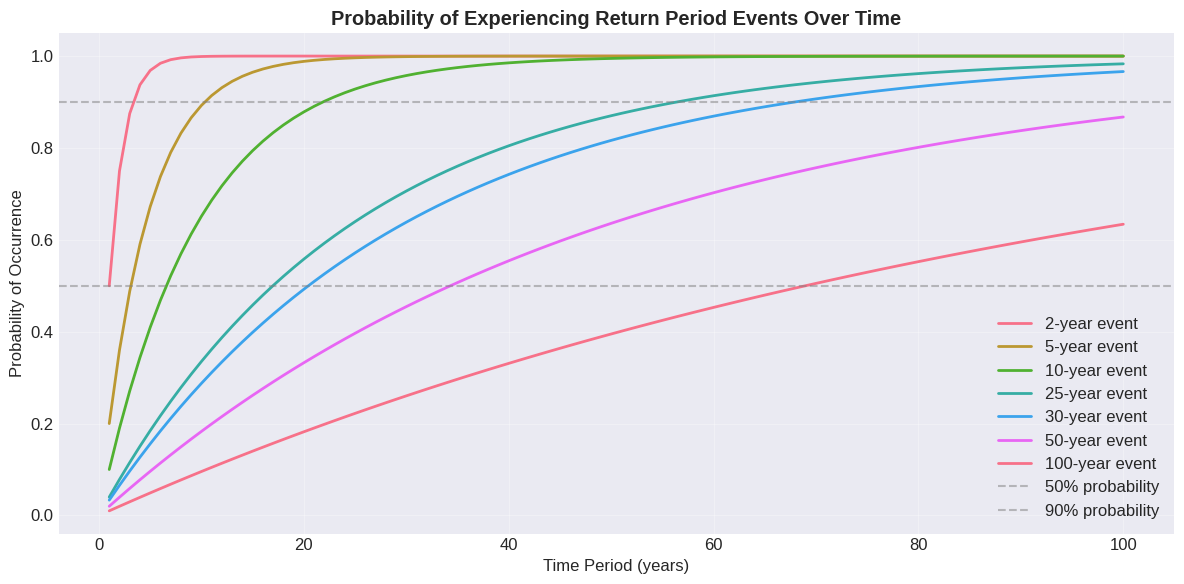

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate exceedance probabilities
years = np.arange(1, 101)
return_periods = [2, 5, 10, 25, 30, 50, 100]

plt.figure(figsize=(12, 6))

for T in return_periods:
    p_annual = 1/T
    # Probability of at least one event in N years = 1 - (1-p)^N
    prob = [1 - (1 - p_annual)**n for n in years]
    plt.plot(years, prob, linewidth=2, label=f'{T}-year event')

plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% probability')
plt.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5, label='90% probability')

plt.xlabel('Time Period (years)')
plt.ylabel('Probability of Occurrence')
plt.title('Probability of Experiencing Return Period Events Over Time', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()